In [37]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import os

%matplotlib inline

In [38]:
from dotenv import load_dotenv
load_dotenv()
FRED_KEY = os.getenv("FRED_KEY")

In [39]:
from urllib.request import urlopen
import json

def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

In [40]:
url = (f"https://api.stlouisfed.org/fred/series/observations?series_id=T10YIE&api_key={FRED_KEY}&file_type=json")
raw_data = get_jsonparsed_data(url)

In [41]:
#raw_data

In [42]:
T10YIE_df = pd.DataFrame(raw_data['observations'])
#T10YIE_df.head()

In [43]:
# convert to datetime
T10YIE_df['Date'] = pd.to_datetime(T10YIE_df['date'])
T10YIE_df.set_index('Date', inplace=True)
T10YIE_df = T10YIE_df.drop(columns=["date", "realtime_start", "realtime_end"]).sort_index()
#T10YIE_df.tail(50)

In [44]:
#Removing "." in data
T10YIE_df = T10YIE_df[T10YIE_df.value != "."]
#T10YIE_df.tail(50)

In [45]:
T10YIE_df['value'] = pd.to_numeric(T10YIE_df['value'],errors='coerce')

# Data Cleaning Function:

In [46]:
# Pulling time series:
def pull_time_series(time_series_code, dataframe_name):

    url = (f"https://api.stlouisfed.org/fred/series/observations?series_id={time_series_code}&api_key={FRED_KEY}&file_type=json")
    raw_data = get_jsonparsed_data(url)
    dataframe_name = pd.DataFrame(raw_data['observations'])
    
    # convert to datetime
    dataframe_name['Date'] = pd.to_datetime(dataframe_name['date'])
    dataframe_name.set_index('Date', inplace=True)
    dataframe_name = dataframe_name.drop(columns=["date", "realtime_start", "realtime_end"]).sort_index()
    dataframe_name['value'] = pd.to_numeric(dataframe_name['value'],errors='coerce')
    return dataframe_name

US_30_Mortgage_df = pull_time_series("MORTGAGE30US", "US_30_Mortgage_df")
Gold_vol_df = pull_time_series("GVZCLS", "Gold_Vol_ETF")
Ten_Minus_Two_spread_df = pull_time_series("T10Y2Y", "Ten_Yr_Yield_Minus_Two_Year")
Gold_vol_df.isnull().sum()

value    112
dtype: int64

In [47]:
# Pull Raw data for model
US_GDP_data = pull_time_series("A191RL1Q225SBEA", "US_GDP_Growth")

US_GDP_df = pull_time_series("GDPC1", "REAL_GDP")
US_Real_PCE_data = pull_time_series("PCEC96", "US_Real_PCE")
US_Initial_Claims_data = pull_time_series("ICSA", "US_Initial_Claims")
US_Cap_Util = pull_time_series("TCU", "US_Capital_Utilization")

In [48]:
# Clean GDP data
US_GDP_df["Real GDP"] = US_GDP_df["value"]
US_GDP_df = US_GDP_df.drop(columns=["value"])
US_GDP_df["Real_GDP_YoY"] = US_GDP_df['Real GDP'].pct_change(4)*100
US_GDP_df["Real_GDP_YoY"] = US_GDP_df["Real_GDP_YoY"].replace(-np.inf, np.nan).dropna()

# Changing date index to last day of the month
US_GDP_df = US_GDP_df.reset_index()
US_GDP_df["Date"] = US_GDP_df["Date"] - pd.Timedelta(1, unit='d')
US_GDP_df.set_index(US_GDP_df["Date"], inplace=True)
US_GDP_df = US_GDP_df.drop(columns=["Date"])
US_GDP_df.tail()


,Real GDP,Real_GDP_YoY
Date,,
2019-03-31,19020.599,1.963163
2019-06-30,19141.744,2.076481
2019-09-30,19253.959,2.338885
2019-12-31,19010.848,0.319261
2020-03-31,17282.188,-9.139623


In [49]:
# Clean GDP data
US_GDP_data["Real GDP"] = US_GDP_data["value"]
US_GDP_data = US_GDP_data.drop(columns=["value"])
#US_GDP_data["Real_GDP_YoY"] = US_GDP_data['Real GDP'].pct_change(12)*100

# Changing date index to last day of the month
US_GDP_data = US_GDP_data.reset_index()
US_GDP_data["Date"] = US_GDP_data["Date"] - pd.Timedelta(1, unit='d')
US_GDP_data.set_index(US_GDP_data["Date"], inplace=True)
US_GDP_data = US_GDP_data.drop(columns=["Date"])
US_GDP_data.tail()

,Real GDP
Date,
2019-03-31,1.5
2019-06-30,2.6
2019-09-30,2.4
2019-12-31,-5.0
2020-03-31,-31.7


In [50]:
# Function to define accelerating or decelerating qoq growth 
US_GDP_data["Rate of Change Growth"] = np.where(US_GDP_data["Real GDP"] >= US_GDP_data["Real GDP"].shift(1), "Accelerating", 
                                                (np.where(US_GDP_data["Real GDP"] < US_GDP_data["Real GDP"].shift(1), "Decelerating", US_GDP_data["Real GDP"])))
US_GDP_data.tail()

,Real GDP,Rate of Change Growth
Date,,
2019-03-31,1.5,Decelerating
2019-06-30,2.6,Accelerating
2019-09-30,2.4,Decelerating
2019-12-31,-5.0,Decelerating
2020-03-31,-31.7,Decelerating


In [51]:
# Clean PCE data
US_Real_PCE_data.rename(columns={"value":"Real_PCE"},inplace=True)
US_Real_PCE_data["Real_PCE_YoY"] = US_Real_PCE_data['Real_PCE'].pct_change(12)*100
US_Real_PCE_data["Real_PCE_YoY"] = US_Real_PCE_data["Real_PCE_YoY"].replace(-np.inf, np.nan).dropna()

# Changing date index to last day of the month
US_Real_PCE_data = US_Real_PCE_data.reset_index()
US_Real_PCE_data["Date"] = US_Real_PCE_data["Date"] - pd.Timedelta(1, unit='d')
US_Real_PCE_data.set_index(US_Real_PCE_data["Date"], inplace=True)
US_Real_PCE_data = US_Real_PCE_data.drop(columns=["Date"])
US_Real_PCE_data.tail()

,Real_PCE,Real_PCE_YoY
Date,,
2020-02-29,12536.1,-4.694532
2020-03-31,10977.0,-16.698919
2020-04-30,11904.1,-9.882964
2020-05-31,12577.6,-5.084029
2020-06-30,12778.2,-3.771368


In [52]:
# Clean Initial Claims data
US_Initial_Claims_data.rename(columns={"value":"Initial_Claims"},inplace=True)

US_Initial_Claims_data_resampled = US_Initial_Claims_data.Initial_Claims.resample('M').sum()
US_Initial_Claims_data_resampled = pd.DataFrame(US_Initial_Claims_data_resampled)

US_Initial_Claims_data_resampled["Initial_Claims_YoY"] = US_Initial_Claims_data_resampled['Initial_Claims'].pct_change(12)*100
US_Initial_Claims_data_resampled["Initial_Claims_YoY"] = US_Initial_Claims_data_resampled["Initial_Claims_YoY"].replace(-np.inf, np.nan).dropna()
US_Initial_Claims_data_resampled.tail()

,Initial_Claims,Initial_Claims_YoY
Date,,
2020-05-31,12329000,1312.256586
2020-06-30,5996000,442.624434
2020-07-31,5475000,540.350877
2020-08-31,5161000,377.428307
2020-09-30,884000,3.755869


In [53]:
# Clean Capacity utilization data
US_Cap_Util.rename(columns={"value": "Capacity Utilization"}, inplace=True)
US_Cap_Util["Capacity Utilization YoY"] = US_Cap_Util["Capacity Utilization"].pct_change(12)*100
US_Cap_Util["Capacity Utilization YoY"] = US_Cap_Util["Capacity Utilization YoY"].replace(-np.inf, np.nan).dropna()

# Changing date index to last day of the month
# US_Cap_Util = US_Cap_Util.reset_index()
# US_Cap_Util["Date"] = US_Cap_Util["Date"] - pd.Timedelta(1, unit='d')
# US_Cap_Util.set_index(US_Cap_Util["Date"], inplace=True)
# US_Cap_Util = US_Cap_Util.drop(columns=["Date"])
# US_Cap_Util.tail()

In [54]:
# Concat dataframes
master_df = pd.concat([US_GDP_data, US_Real_PCE_data,US_Initial_Claims_data_resampled], axis="columns", join='inner')

master_df = master_df.iloc[-50:,:]
master_df

,Real GDP,Rate of Change Growth,Real_PCE,Real_PCE_YoY,Initial_Claims,Initial_Claims_YoY
Date,,,,,,
2007-12-31,-2.3,Decelerating,10665.8,0.988505,1741000,7.469136
2008-03-31,2.1,Accelerating,10659.3,0.768576,1817000,17.453135
2008-06-30,-2.1,Decelerating,10604.6,-0.070674,1533000,-2.728426
2008-09-30,-8.4,Decelerating,10514.9,-1.390764,1856000,18.442884
2008-12-31,-4.4,Accelerating,10500.6,-1.548876,2256000,29.580701
2009-03-31,-0.6,Accelerating,10408.5,-2.352875,2637000,45.129334
2009-06-30,1.5,Accelerating,10458.3,-1.379590,2393000,56.099152
2009-09-30,4.5,Accelerating,10465.9,-0.466005,2190000,17.995690
2009-12-31,1.5,Decelerating,10488.1,-0.119041,1942000,-13.918440


# Determining Macro environment

# US Inflation Analysis

In [21]:

# Pull 5yr-5yr forward inflation expectation raw data
inflation_exp_df = pull_time_series("T5YIFR", "Inflation_Expectations")

# Clean DataFrame
inflation_exp_df["Rate"] = inflation_exp_df["value"]
inflation_exp_df = inflation_exp_df.drop(columns=["value"])
#inflation_exp_df["Rate_YoY"] = inflation_exp_df['Rate'].pct_change(12)*100
# Function to define accelerating or decelerating qoq growth 
inflation_exp_df["Rate of Change Growth"] = np.where(inflation_exp_df["Rate"] >= inflation_exp_df["Rate"].shift(1), "Accelerating", 
                                                (np.where(inflation_exp_df["Rate"] < inflation_exp_df["Rate"].shift(1), "Decelerating", inflation_exp_df["Rate"])))
inflation_exp_df.tail()

,Rate,Rate of Change Growth
Date,,
2020-09-04,1.83,Accelerating
2020-09-07,NaN,nan
2020-09-08,1.81,1.81
2020-09-09,1.85,Accelerating
2020-09-10,1.84,Decelerating


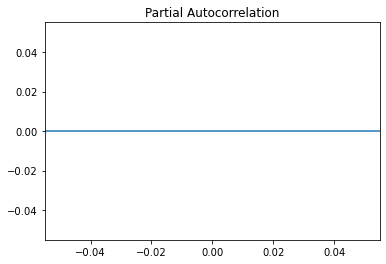

In [22]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sm.graphics.tsaplots.plot_pacf(inflation_exp_df["Rate"], lags=100, zero=False);

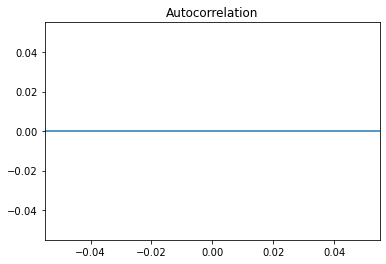

In [23]:
plot_acf(inflation_exp_df["Rate"], lags=10);

# US GDP Growth Analysis
## Autocorrelation/Partial Autocorrelation Analysis - lagged values

In [24]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

US_GDP_data["Lagged QoQ GDP"] = US_GDP_data["Real GDP"].shift(1)
US_GDP_data.tail()

,Real GDP,Rate of Change Growth,Lagged QoQ GDP
Date,,,
2019-03-31,1.5,Decelerating,2.9
2019-06-30,2.6,Accelerating,1.5
2019-09-30,2.4,Decelerating,2.6
2019-12-31,-5.0,Decelerating,2.4
2020-03-31,-31.7,Decelerating,-5.0


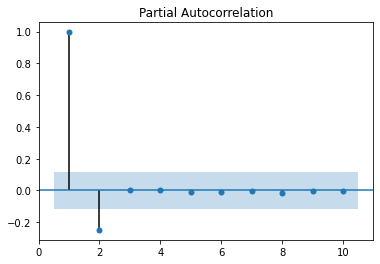

In [25]:
sm.graphics.tsaplots.plot_pacf(US_GDP_df["Real GDP"], lags=10, zero=False);

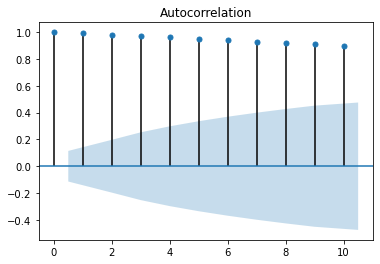

In [26]:
plot_acf(US_GDP_df["Real GDP"], lags=10);

## Linear Regression Model

In [27]:
from sklearn.linear_model import LinearRegression
X = master_df["Real GDP"].to_frame()
y = master_df.drop(columns=["Real GDP", "Rate of Change Growth", "Real_PCE", "Initial_Claims"])
y.tail()

,Real_PCE_YoY,Initial_Claims_YoY
Date,,
2019-03-31,2.433052,-3.628319
2019-06-30,2.440078,-0.180668
2019-09-30,2.299855,-19.849483
2019-12-31,2.691925,-17.668488
2020-03-31,-16.698919,879.522498


In [28]:
# Create a model with scikit-learn
model = LinearRegression()
model

LinearRegression()

In [29]:
y.isnull().sum()

Real_PCE_YoY          0
Initial_Claims_YoY    0
dtype: int64

In [30]:
# Fit the data into the model
model.fit(X, y)

LinearRegression()

In [31]:
# The model creates predicted y values based on X values
predicted_y_values = model.predict(X)

In [32]:
# Relevant metrics - score, r2, mse, rmse, std
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

score = model.score(X, y, sample_weight=None)
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)

In [33]:
# Print releveant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The score is 0.7713589201133366.
The r2 is 0.7713589201133366.
The mean squared error is 1701.791631338497.
The root mean squared error is 41.252777256064796.
The standard deviation is Real_PCE_YoY            2.980817
Initial_Claims_YoY    124.822680
dtype: float64.


## ARMA Model

In [34]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(master_df["Real GDP"].values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [35]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                     ARMA(2, 1)   Log Likelihood                -147.249
Method:                       css-mle   S.D. of innovations              4.542
Date:                Fri, 11 Sep 2020   AIC                            304.498
Time:                        09:05:51   BIC                            314.058
Sample:                             0   HQIC                           308.139
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8417      3.092     -0.272      0.785      -6.901       5.218
ar.L1.y        0.9780      0.789      1.240      0.215      -0.568       2.524
ar.L2.y       -0.2716      0.682     -0.398      0.690      -1.608       1.065
ma.L1.y        0.1062      0.732      0.145      0.885      -1.328       1.541
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8002           -0.6639j            1.9187           -0.0562
AR.2            1.8002           +0.6639j            1.9187            0.0562
MA.1           -9.4131           +0.0000j            9.4131            0.5000
-----------------------------------------------------------------------------
"""

# Creating a Line Chart Function

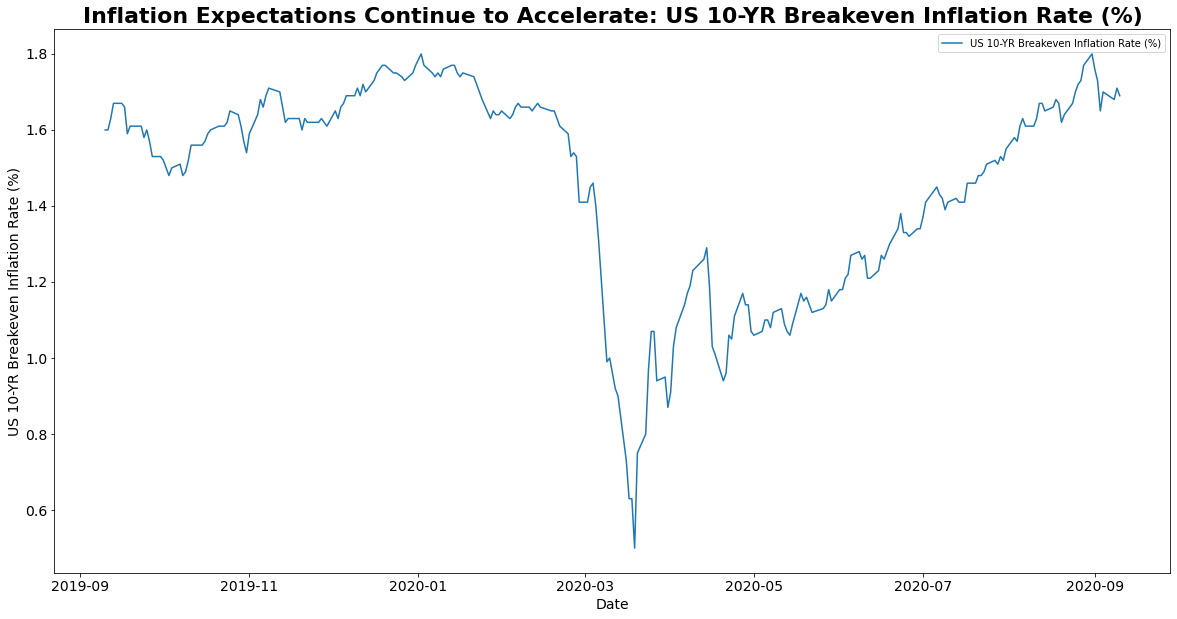

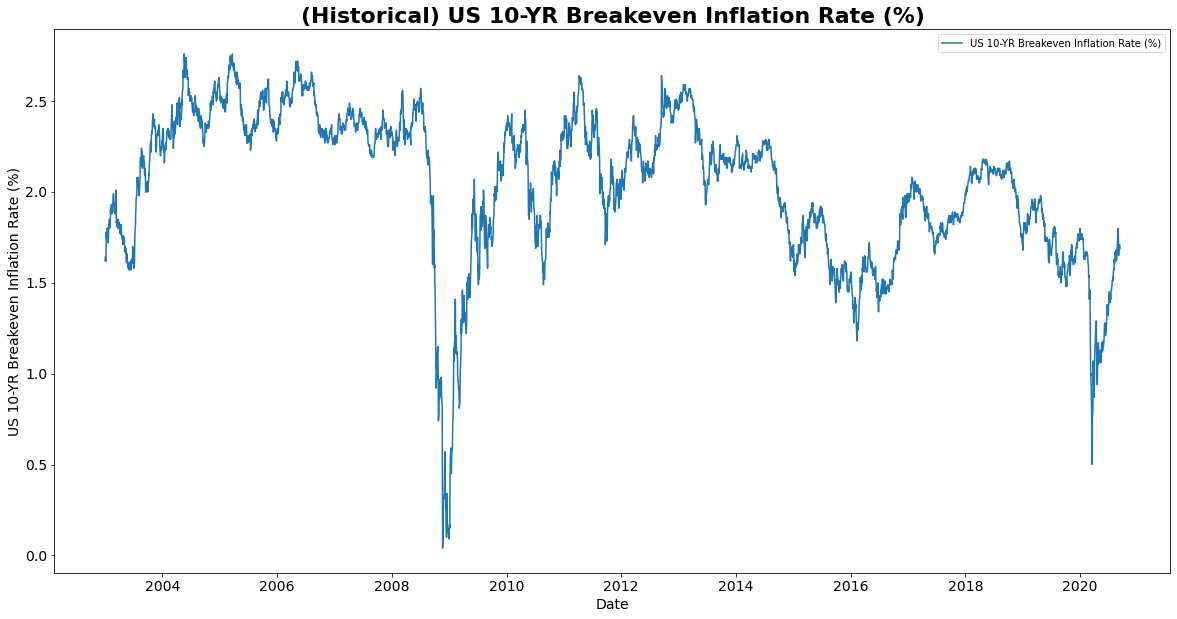

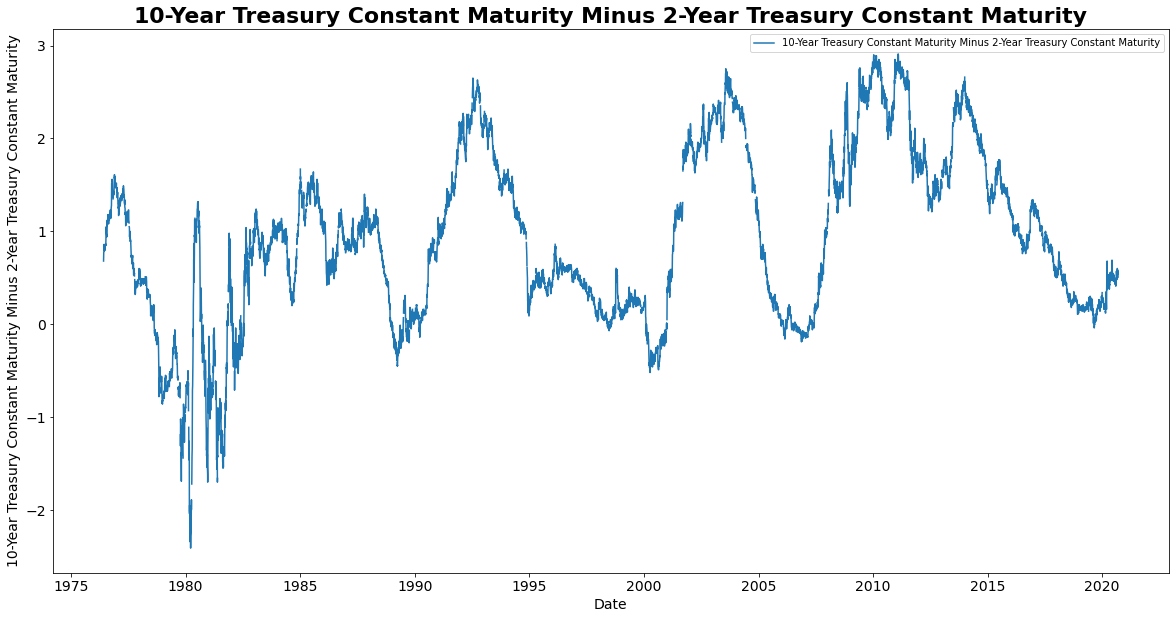

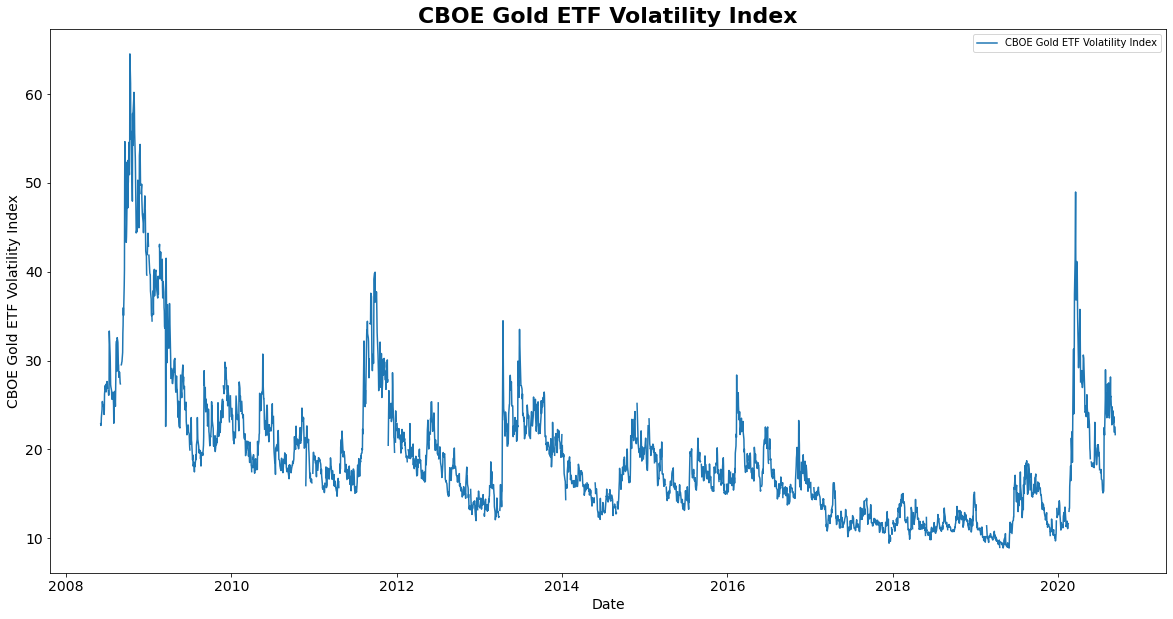

In [36]:
# Create plot function
def create_plot(x_axis_data, y_axis_data, y_axis_label, title):
    plt.subplots(figsize=(20,10))
    plt.plot(x_axis_data, y_axis_data, label=y_axis_label)
    plt.legend()
    plt.xlabel("Date",  fontdict={'fontsize':'14'})
    plt.ylabel(y_axis_label,  fontdict={'fontsize':'14'})
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.title(title, fontdict={'fontweight':'bold', 'fontsize':'22'})
    plt.savefig(f'Images/FRED/{title}.png', bbox_inches="tight")

create_plot(T10YIE_df.index[-252:], 
            T10YIE_df["value"][-252:], 
            "US 10-YR Breakeven Inflation Rate (%)",
           "Inflation Expectations Continue to Accelerate: US 10-YR Breakeven Inflation Rate (%)")
#create_plot(US_30_Mortgage_df.index, 
 #           US_30_Mortgage_df["value"], 
  #          "30-YR Fixed Rate Mortgage Average in the US", 
   #         "Mortgage Rates Pushing New Lows")
create_plot(T10YIE_df.index, 
            T10YIE_df["value"], 
            "US 10-YR Breakeven Inflation Rate (%)",
           "(Historical) US 10-YR Breakeven Inflation Rate (%)")
create_plot(Ten_Minus_Two_spread_df.index, 
            Ten_Minus_Two_spread_df["value"], 
            "10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity", 
            "10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity")
create_plot(Gold_vol_df.index, 
            Gold_vol_df["value"], 
            "CBOE Gold ETF Volatility Index", 
            "CBOE Gold ETF Volatility Index")

# Model Work

In [ ]:
# Pull raw data
url = (f"https://api.stlouisfed.org/fred/series/observations?series_id=T10YIE&api_key={FRED_KEY}&file_type=json")
raw_data = get_jsonparsed_data(url)